In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline 
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

# Load Data

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


# Understand the data

In [4]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [5]:
# There are 3 columns with missing values: 'Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads'
missing_percentages = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)
print('Test data missing values')
print('-'*40)
missing_percentages = (df_test.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)

Guest_Popularity_percentage    19.470667
Episode_Length_minutes         11.612400
Number_of_Ads                   0.000133
dtype: float64
Test data missing values
----------------------------------------
Guest_Popularity_percentage    19.5328
Episode_Length_minutes         11.4944
dtype: float64


In [6]:
# Therefor we will delete all the rows with missing values
# which can make that data not impact the final outcome
# Number_of_Ads with 0.000133% of null value, so we will fill it with the median value
df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)
df.dropna(inplace=True)

# same result with the test data
df_test.dropna(inplace=True)
# After dropping the missing values, there will be 539049 rows


/var/folders/vt/b2_6nfwd4hd21p6_6172lfvc0000gn/T/ipykernel_96986/3382702320.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)


# Data exploration and featuring data


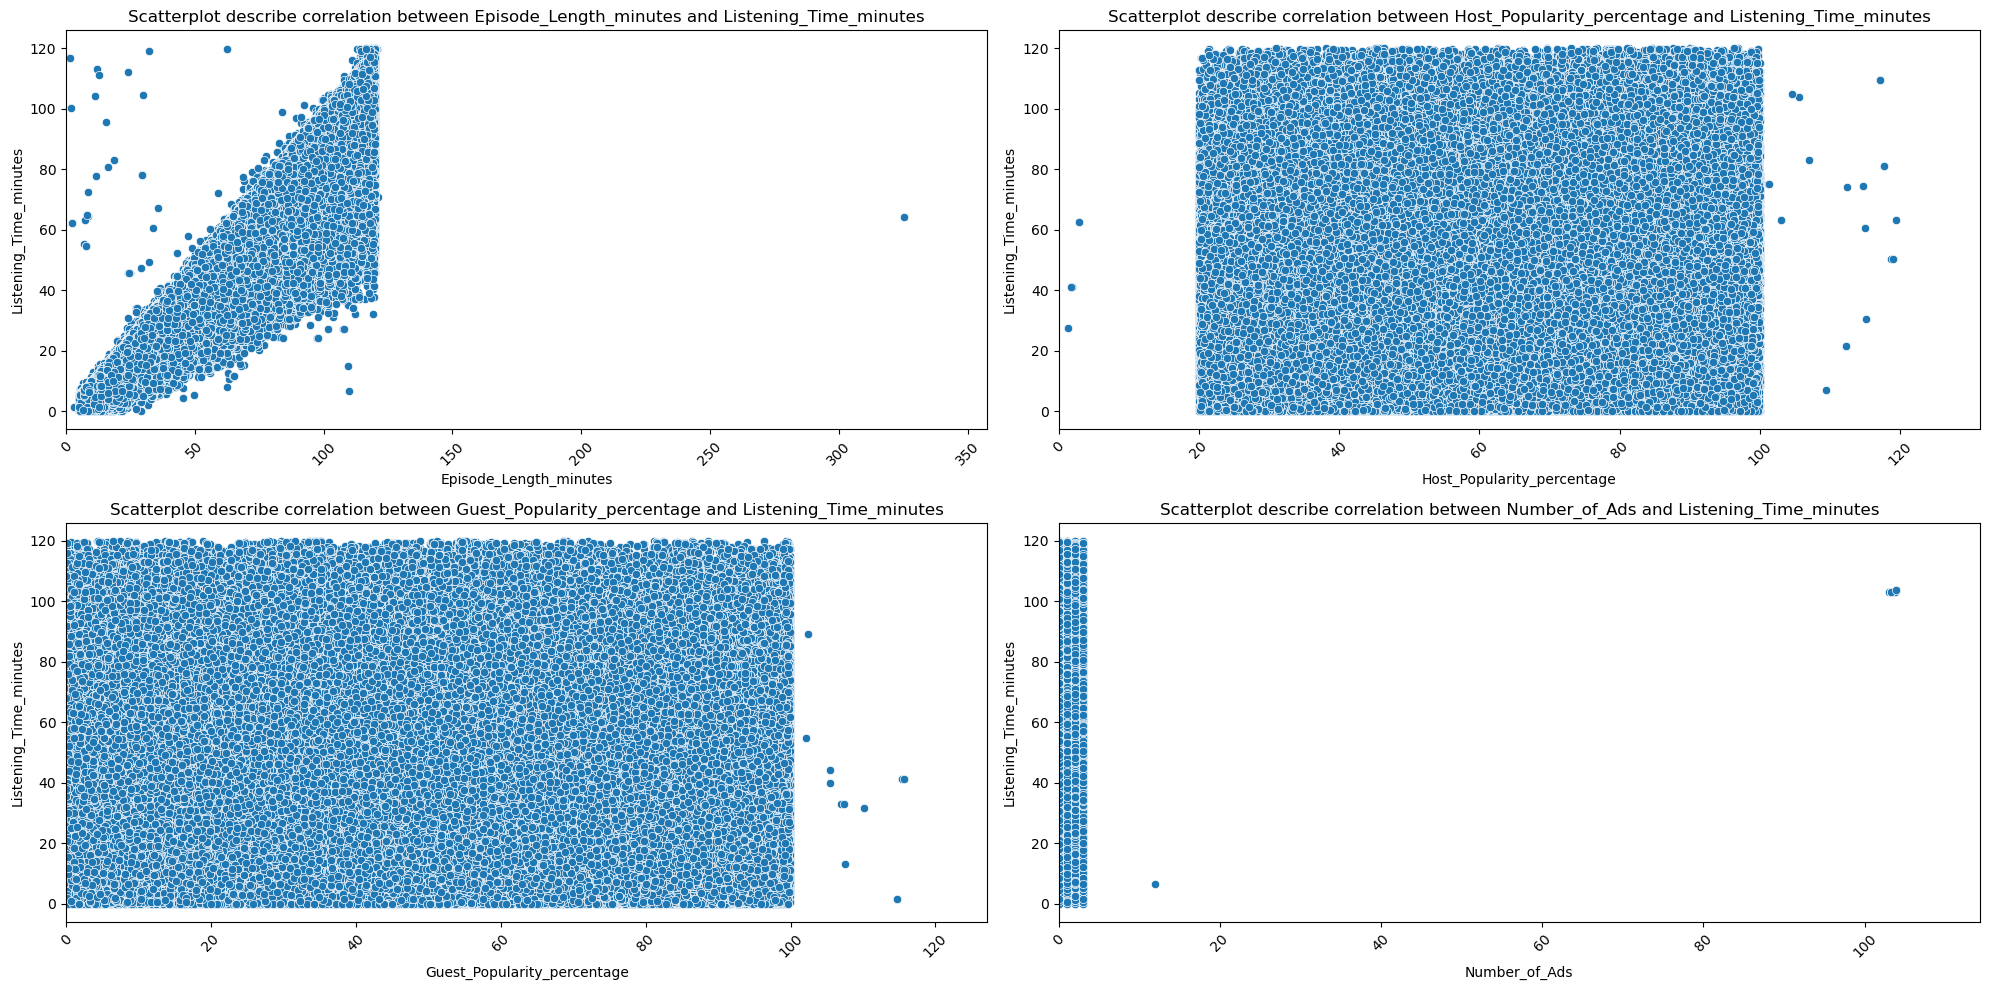

In [7]:
scatter = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'ratio_Ads']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, i in zip(axes, scatter):
    sns.scatterplot(data = df,x = i, y = 'Listening_Time_minutes',ax = ax)
    ax.set_title(f'Scatterplot describe correlation between {i} and Listening_Time_minutes')
    ax.set_xlabel(i)
    ax.set_ylabel('Listening_Time_minutes')
    ax.set_xlim(0, df[i].max() * 1.1)
    for i in ax.get_xticklabels():
        i.set_rotation(45)
plt.tight_layout()
plt.show()
# Except Episode_Length_minutes, the other columns dont have a linear correlation with Listening_Time_minutes
# So we will feature all these columns

In [8]:
def popular(df):
    avg_popularity = (df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage']) / 2
    if avg_popularity <= 20:
        return 'Not Popular'
    elif 20 < avg_popularity <= 50:
        return 'Average'
    elif 50 < avg_popularity <= 75:
        return 'Popular'
    else:
        return 'Very Popular'

df['Popular_Level'] = df.apply(popular, axis=1)
df.drop(columns=['Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)
df_test['Popular_Level'] = df_test.apply(popular, axis=1)
df_test.drop(columns=['Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)

In [9]:
df['Episode_Title'] = df['Episode_Title'].str.replace('Episode ', '').astype(int)
df_test['Episode_Title'] = df_test['Episode_Title'].str.replace('Episode ', '').astype(int)

# Now we will feature the Episode_Title column, by using the episode number to find out the age of the episode
def episode(df):
    if df['Episode_Title'] <= 20:
        return 'Newbie'
    elif 20 < df['Episode_Title'] <= 50:
        return 'Growing'
    else:
        return 'Oldbie'
df['Episode_Age'] = df.apply(episode, axis=1)
df_test['Episode_Age'] = df_test.apply(episode, axis=1)
df.drop(columns=['Episode_Title'], inplace=True)
df_test.drop(columns=['Episode_Title'], inplace=True)


In [10]:
def week(df):
    if df['Publication_Day'] in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

df['Publication_Day'] = df.apply(week, axis=1)
df_test['Publication_Day'] = df_test.apply(week, axis=1)

In [11]:
# Now we will find the ratio of Episode_Length_minutes, Number_of_Ads
df['ratio_Ads'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
df_test['ratio_Ads'] = df['Number_of_Ads'] / df['Episode_Length_minutes']

In [12]:
def genre(df):
    if df['Genre'] in ['Comedy', 'Music', 'Lifestyle']:
        return 'Entertainment'
    elif df['Genre'] in ['News', 'True Crime', 'Business']:
        return 'Events News'
    elif df['Genre'] in ['Health', 'Education', 'Technology']:
        return 'Information'
    elif df['Genre'] in ['Sports']:
        return 'Sports'
    else:
        return 'Other'
df['Genre'] = df.apply(genre, axis=1)
df_test['Genre'] = df_test.apply(genre, axis=1)

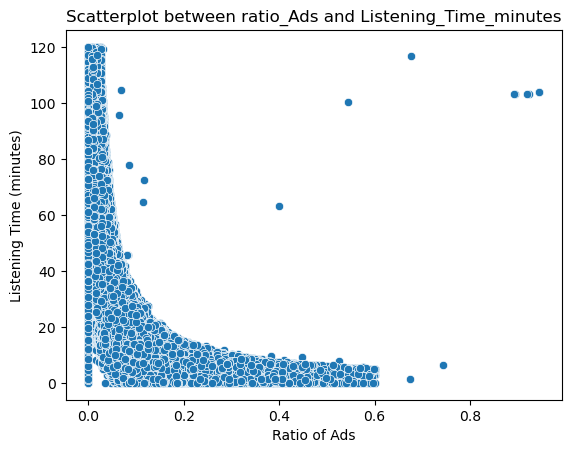

In [13]:
sns.scatterplot(data=df, x='ratio_Ads', y='Listening_Time_minutes')
plt.title('Scatterplot between ratio_Ads and Listening_Time_minutes')
plt.xlabel('Ratio of Ads')
plt.ylabel('Listening Time (minutes)')
plt.show()

>Visualization all the categories variables# 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

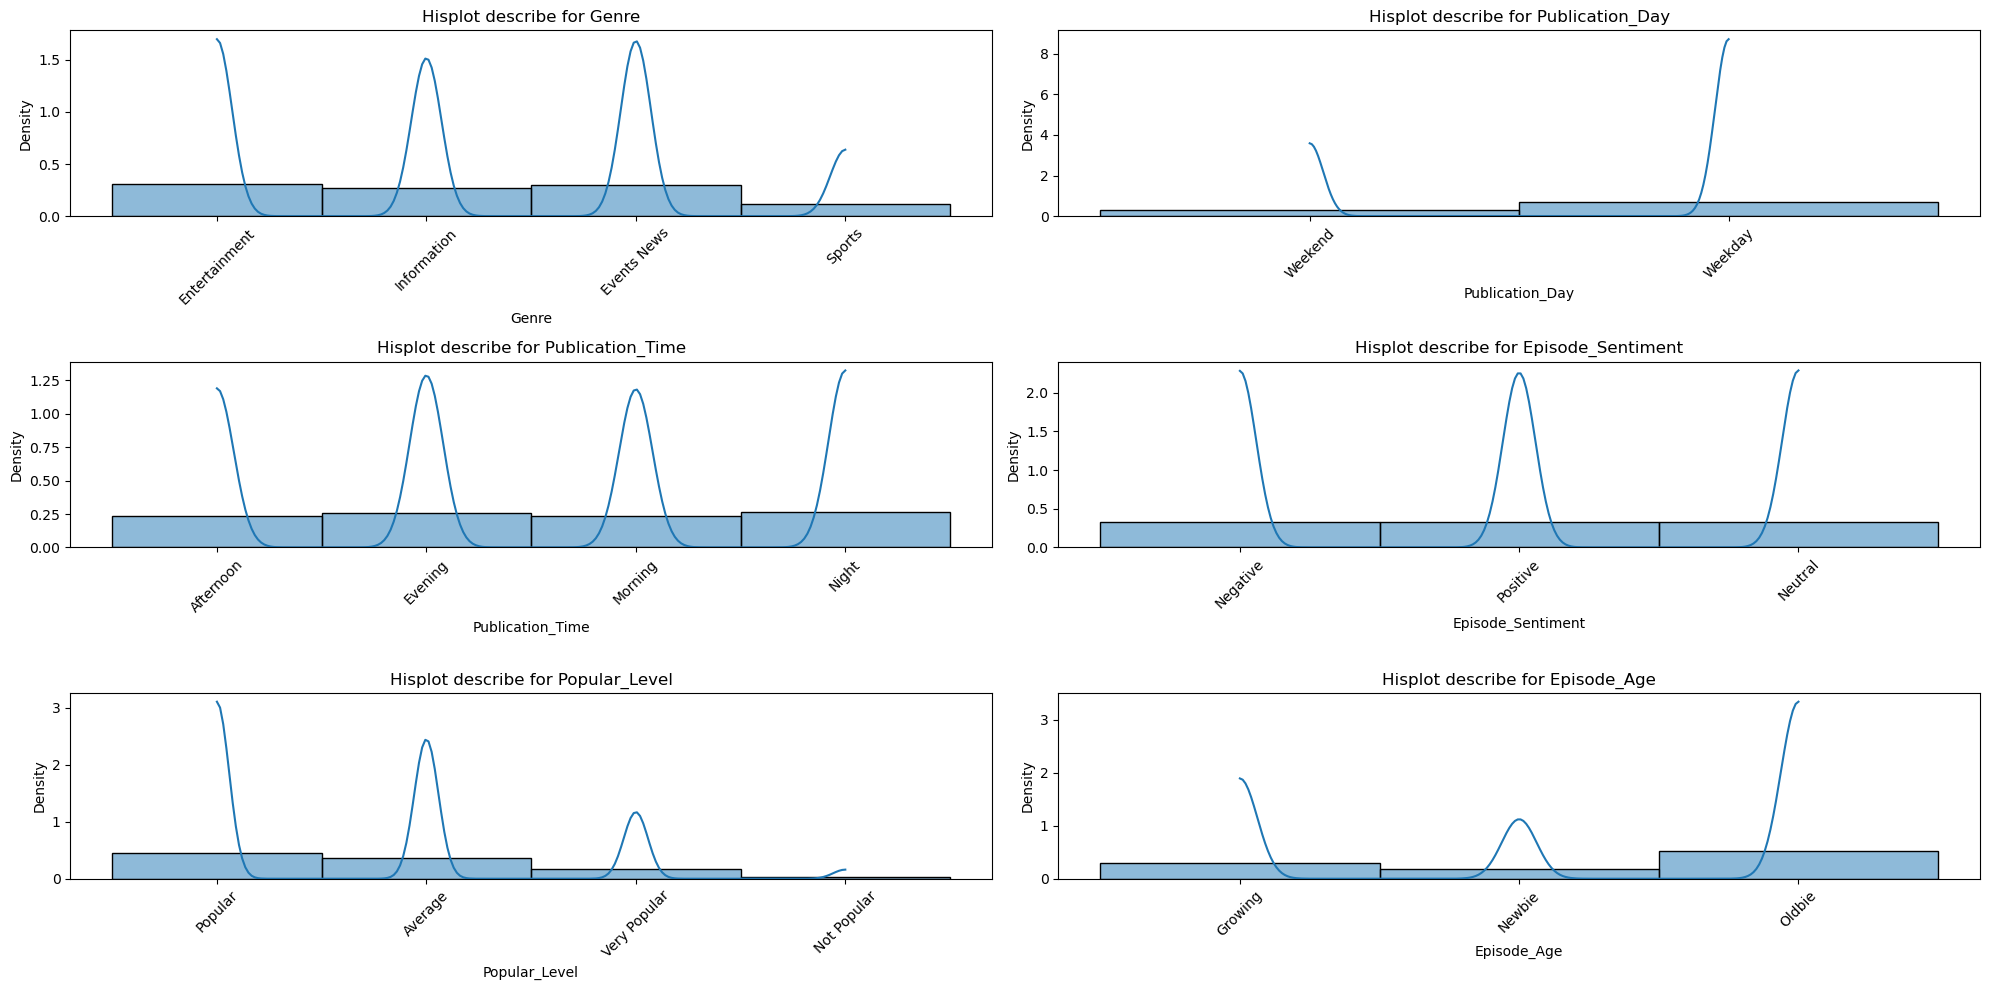

In [14]:
objects = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'Popular_Level', 'Episode_Age']
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()
for ax, i in zip(axes, objects):
    sns.histplot(data = df,x = i,ax = ax, kde=True, stat='density', bins=30)
    ax.set_title(f'Hisplot describe for {i}')
    ax.set_xlabel(i)
    for i in ax.get_xticklabels():
        i.set_rotation(45)
plt.tight_layout()
plt.show()

> Creating Boxplot and Countplot 

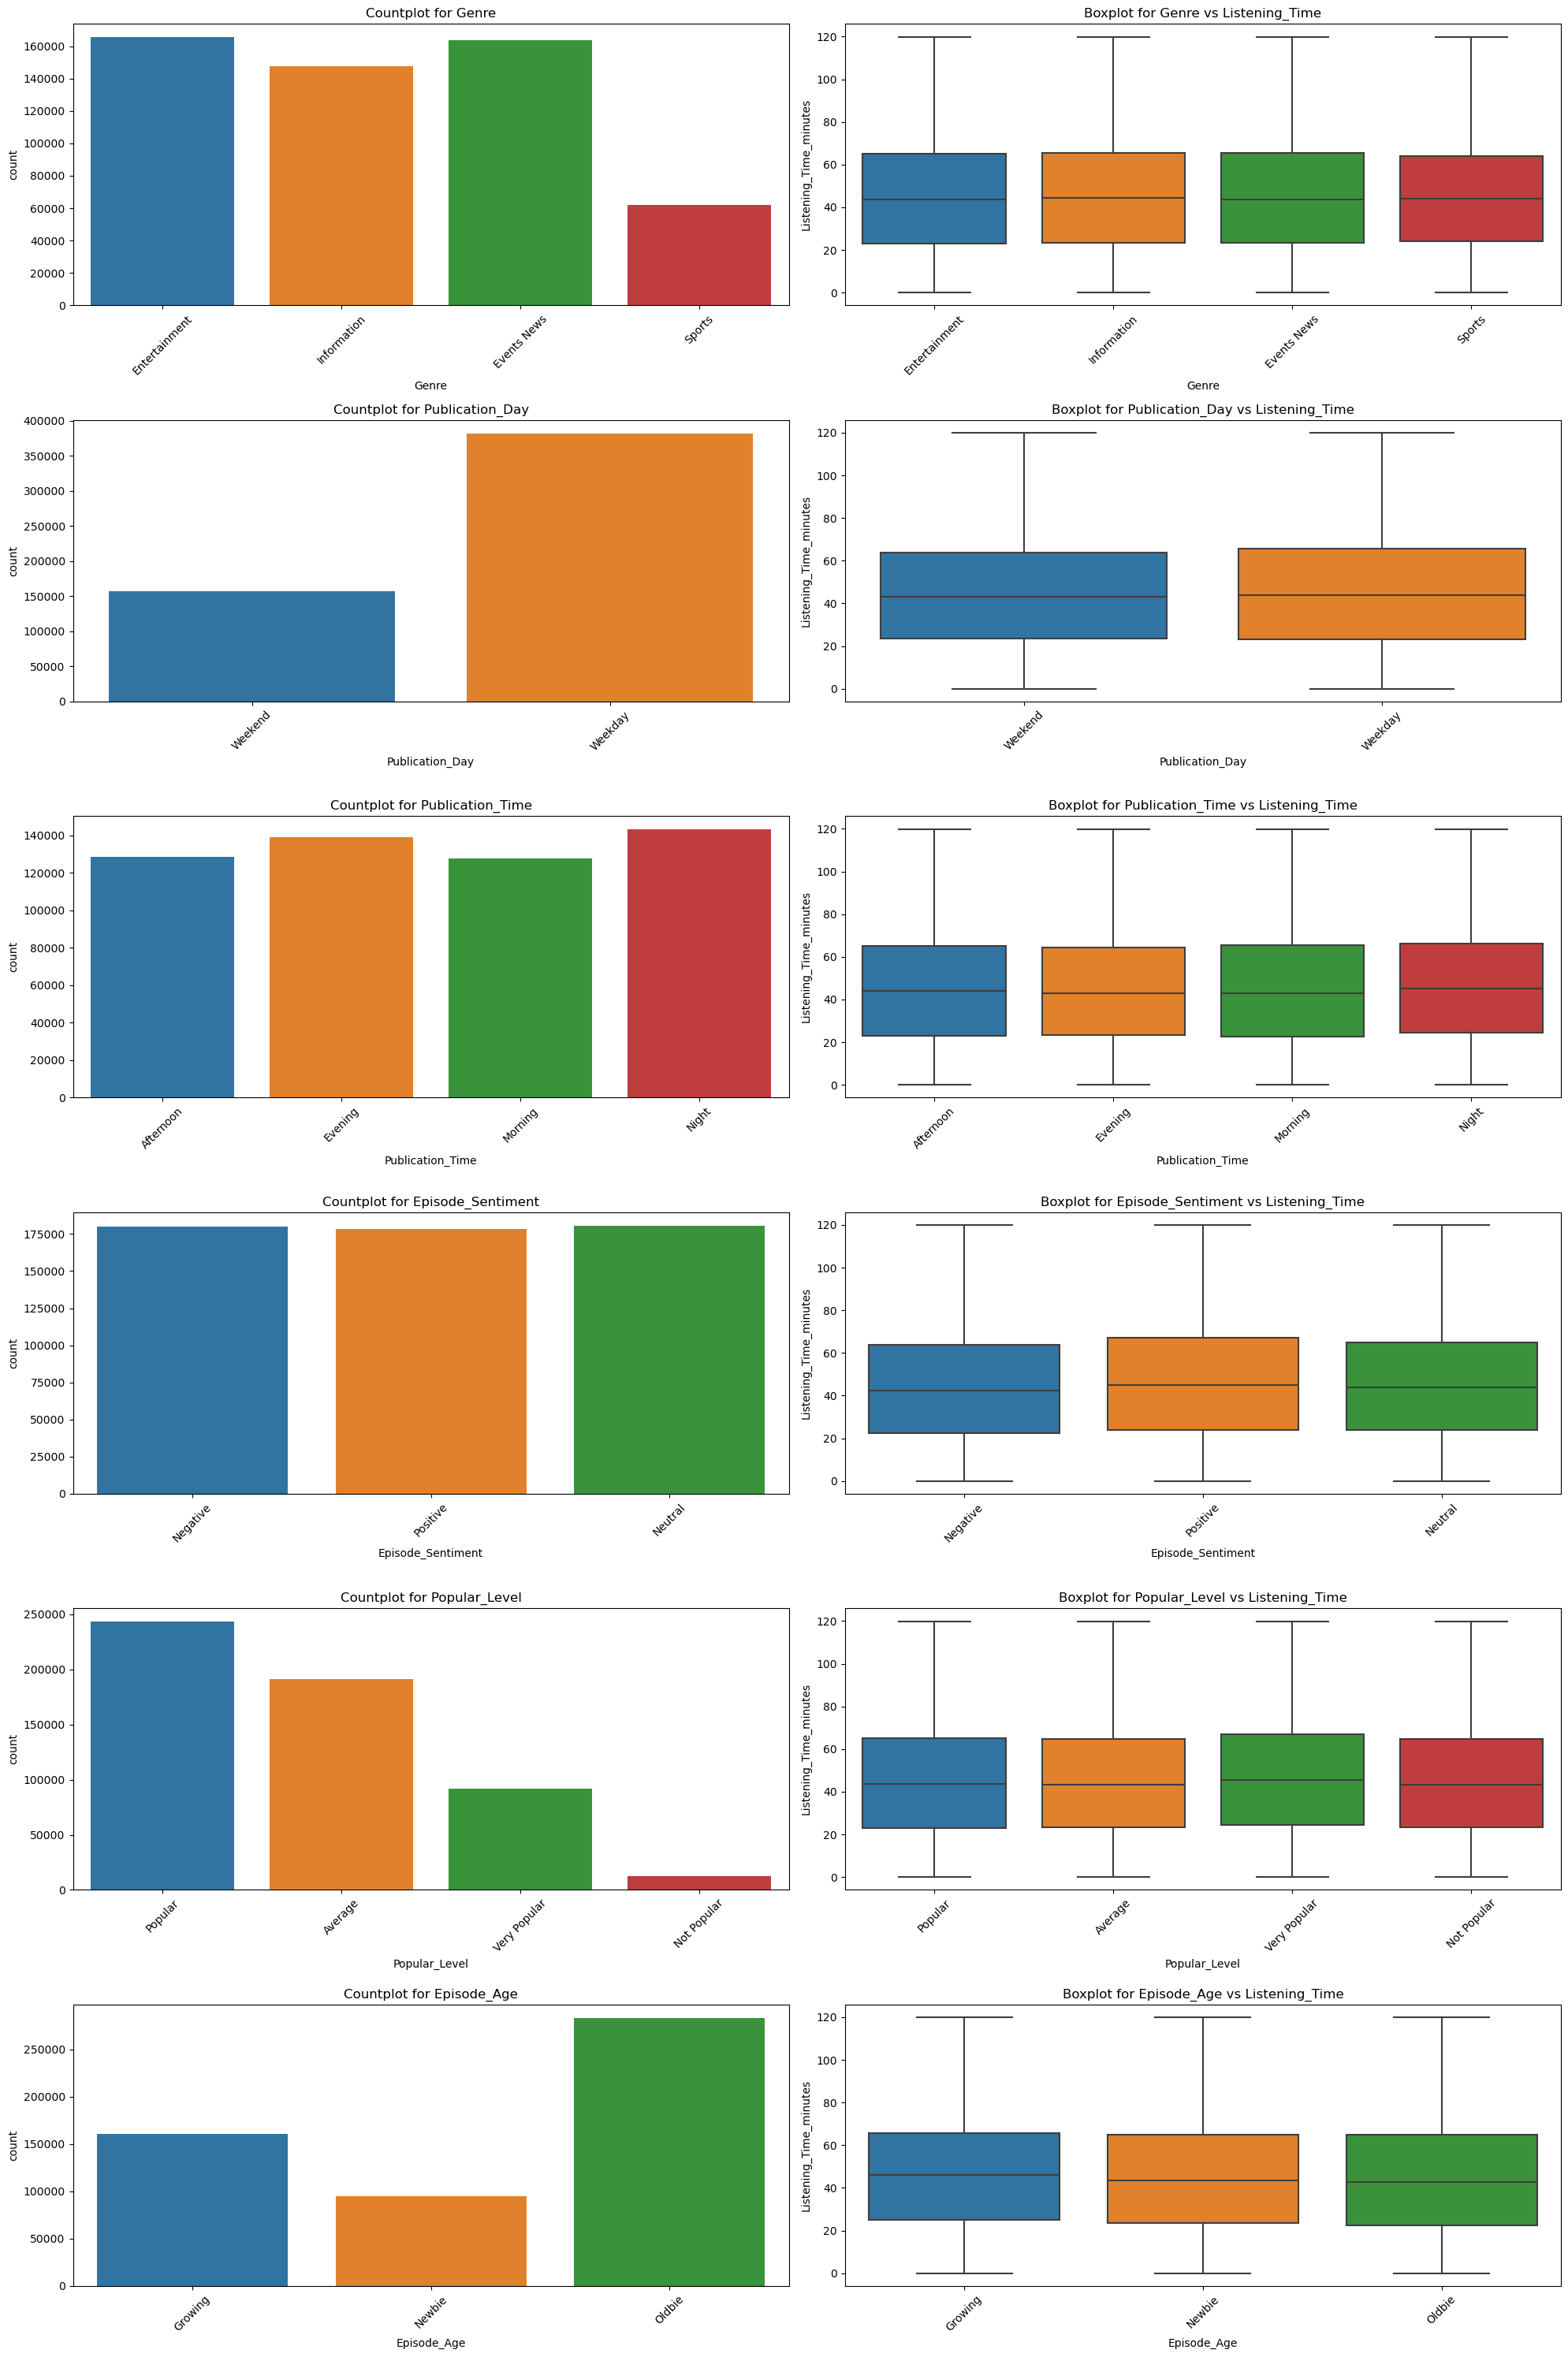

In [15]:
fig, axes = plt.subplots(6, 2, figsize=(20, 30)) 
axes = axes.flatten()

for idx, col in enumerate(objects):
    sns.countplot(data=df, x=col, ax=axes[2*idx])
    axes[2*idx].set_title(f'Countplot for {col}')
    axes[2*idx].set_xlabel(col)
    for label in axes[2*idx].get_xticklabels():
        label.set_rotation(45)
    
    sns.boxplot(data=df, x=col, y='Listening_Time_minutes', ax=axes[2*idx+1])
    axes[2*idx+1].set_title(f'Boxplot for {col} vs Listening_Time')
    axes[2*idx+1].set_xlabel(col)
    for label in axes[2*idx+1].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

# Data Preparation and Model 

In [16]:
mood = ['Negative', 'Neutral', 'Positive']
popularity = ['Not Popular','Average', 'Popular','Very Popular']
age = ['Newbie','Growing','Oldbie']
ord = OrdinalEncoder(categories=[mood, popularity, age])

columns_ordinal_encode = ['Episode_Sentiment', 'Popular_Level','Episode_Age']
columns_label_encode = ['Genre', 'Publication_Day', 'Publication_Time']
num_cols = ['Episode_Length_minutes', 'Number_of_Ads', 'ratio_Ads']

X = df.drop(columns=['id', 'Listening_Time_minutes', 'Podcast_Name'])
Y = df['Listening_Time_minutes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
preprocessing = ColumnTransformer([
    ('Ordinal', ord, columns_ordinal_encode),
    ('LabelEncoder', OrdinalEncoder(), columns_label_encode),
    ('StandardScaler', StandardScaler(), num_cols),
])
input = [
    ('preprocess', preprocessing),
    ('model', Ridge())]
pipe = Pipeline(input)


In [18]:
param_grid = [
    {
        'model': [LinearRegression()],
    },
    {
        'model': [Ridge()],
        'model__alpha': [0.1, 0.5, 5, 7],
        'model__max_iter': [50, 100]
    },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [4, 5, 6]
    },
    {
        'model': [xgb.XGBRegressor()],
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1, 0.2, 0.5],
        'model__max_depth': [5, 6, 8]
    },
    {
        'model': [lgb.LGBMRegressor()],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2, 0.5],
        'model__boosting_type': ['gbdt', 'dart', 'goss']
    }
]

In [19]:
k_cv = KFold(n_splits=4, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=k_cv, scoring= 'r2')
grid_search.fit(X_train, Y_train)

print('Best score of the model is: ')
print(f"Best score: {grid_search.best_score_}")
print(f"Which will use the model: \n {grid_search.best_estimator_}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 323429, number of used features: 9
[LightGBM] [Info] Start training from score 45.845467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 323429, number of used features: 9
[LightGBM] [Info] Start training from score 45.826196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [20]:
Y_pred_train = grid_search.best_estimator_.predict(X_train)
print(mean_squared_error(Y_train , Y_pred_train))

107.40496723608872


In [21]:
print(f'Root_mean_square_error is: {np.sqrt(mean_squared_error(Y_train , Y_pred_train))}')

Root_mean_square_error is: 10.363636776541753


# My Submission

In [22]:
df_test['predict'] = grid_search.best_estimator_.predict(df_test.drop(columns = ['id', 'Podcast_Name']))
df_submission = pd.DataFrame(
        {
            "id": df_test['id'],
            "Listening_Time_minutes": df_test['predict']
        }
    )

In [23]:
df_submission.to_csv("submission.csv", index=False)
